# 0.0 Modules, etc.

In [ ]:
import numpy as np
import pandas as pd
import multiprocessing

import scipy
from scipy import spatial
from scipy.spatial import cKDTree

import sklearn as sk
from sklearn import svm
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import clone
from sklearn.externals.six.moves import xrange

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline

%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

In [ ]:
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

In [ ]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
# plotly.tools.set_credentials_file(username='duplinskiy', api_key='RsZHhxIiAGGu7FN9P4bu')
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf

cf.go_offline()

# 1 Preprocessing

## 1.1 Wrangling

In [ ]:
%%time
dat0 = pd.read_csv('seasonal_sales_indicators.csv',
                 delimiter = '~')

# len(dat0['article_number'].unique()) # 46573

dat = dat0.copy()

dat.columns = [x.replace('t_eu_ecom_dit_dsf_transaction_t.', '') for x in dat.columns] # tidy column names

dat = dat[dat['gross_demand_quantity'] != 0] 

Data

    (0) dat0
    (1) dat

In [ ]:
# Feature subset for clustering

dat = dat[['article_number', 
           'gross_demand_quantity', # mean, sum, std
           'fraction_of_full_price', # mean, std
           'markdown', # mean (INDICATOR) 
           'sale', # mean (INDICATOR no/sale)
           'gross_sales_net_disc_gross_ret']]

dat['sales_price'] = dat['gross_sales_net_disc_gross_ret'].divide(dat['gross_demand_quantity'])
dat.drop('gross_sales_net_disc_gross_ret', axis = 1, inplace = True)

In [ ]:
%%time

dat_grouped = dat.groupby(by = 'article_number')

dat = dat_grouped.agg(['mean', 'std']) # Need count
dat.drop([('markdown', 'std'),('sale', 'std')], axis = 1, inplace=True)
dat[('gross_demand_quantity','sum')] = dat_grouped['gross_demand_quantity'].sum()

dat.fillna(value=0, inplace = True) # Define single transaction article std to be 0
dat = dat.replace([np.inf, -np.inf, np.nan], 0)

## 1.2 Save/Load curated data

In [ ]:
# Save/load tidied version

# dat.to_csv('dat.csv')

dat = pd.read_csv('dat.csv', low_memory=False, index_col = 0, header = [0,1]) # gotta encode multi-index

# 2 Clustering 

## 2.0 Baseline: feature-based

### 2.0.1 Sort

In [ ]:
feature = 'sales_price'
stat = 'mean'

dat_feature_sorted = dat.sort_values([(feature, stat)], ascending=False) # Sort

# # --- Feature cumulative sum ---
# dat_feature_sorted['cumulative_feature'] = dat_feature_sorted[feature][stat].cumsum()

# # --- Feature cumulative percent ---
# total = dat_feature_sorted[feature][stat].sum() 
# dat_feature_sorted['cumulative_pct_feature'] = dat_feature_sorted[feature][stat].cumsum()/total

# # --- Cumulative percent of articles ---
# t = pd.Series(range(1, 46573))/46572
# dat_feature_sorted['cumulative_pct_articles'] = t.values

# --- Add feature based cluster; i.e. top X are labelled non-basic ---
f = pd.DataFrame(np.concatenate([np.ones(8483), np.zeros(38089)]))

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(dat_feature_sorted)
dat_feature_sorted_scaled = scaler.transform(dat_feature_sorted)

pca = PCA(n_components=2) # keep the first two principal components of the data
pca.fit(dat_feature_sorted_scaled)

# transform data onto the first two principal components
dat_pca = pd.DataFrame(pca.transform(dat_feature_sorted_scaled))


### 2.0.2 Plots

In [ ]:
# --- 1 ----
plt.rcParams["figure.figsize"] = [16,5]

plt.scatter(dat_pca[0], 
            dat_pca[1], 
            c = f[0],
            alpha = 0.5)

plt.colorbar()

plt.title('Basic and Non-basic')
plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 1')


# --- 2 ----
plt.plot(dat_feature_sorted['cumulative_pct_articles'], 
         dat_feature_sorted['cumulative_pct_feature'],
        linewidth = 3)

# plt.xlabel('Percent of Articles')
# plt.ylabel('Percent of Feature of Interst')

plt.rcParams["figure.figsize"] = [6,6]
plt.title('Majority, from a Minority of Articles')


# --- 3 ----
import plotly.graph_objs as go

trace1 = go.Scatter(
    x = dat_feature_sorted['cumulative_pct_articles'],
    y = dat_feature_sorted['cumulative_pct_feature'],
    mode = 'lines',
    name = '45 degree line'
)


data = [trace1]
iplot(data, filename='scatter-mode')

## 2.01 Scale (for ML approaches)

In [ ]:
# SCALING: zero mean and unit variance 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dat)
dat_scaled = pd.DataFrame(scaler.transform(dat), columns = dat.columns, index = dat.index)

## 2.1 k-means

### 2.1.1 Model

In [ ]:
%%time

# K-means clustering  --------------------  --------------------
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 4)
kmeans.fit(dat_scaled)

Kmeans = pd.Series(kmeans.predict(dat_scaled)) # Cluster assignments

# Cluster counts
print(Kmeans.value_counts())
print()

In [ ]:
Kmeans = (Kmeans != 0)*1 # lone vector
Kmeans.value_counts()

# k = pd.DataFrame({'kmeans': Kmeans.values}, index = dat_scaled.index)


### 2.1.2 Plots

In [ ]:
import matplotlib as mpl

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
pd.plotting.scatter_matrix(
    dat[[
        ('gross_demand_quantity', 'mean'), 
        ('gross_demand_quantity', 'std'),
        ('sales_price', 'mean'), 
        ('gross_demand_quantity', 'sum')
        ]], 
    figsize=(10,10),
    diagonal='kde',
    c = Kmeans, 
    alpha = 0.5
)

In [ ]:
plt.subplot(2, 1, 1)
plt.scatter(dat['gross_demand_quantity']['mean'], 
            dat['sales_price']['mean'], 
            c = Kmeans,
            alpha = 0.5)
plt.title('Sale Price vs. Gross Demand Quantity')
plt.ylabel('Sale Price')

plt.subplot(2, 1, 2)
plt.scatter(dat['gross_demand_quantity']['sum'], 
            dat['sales_price']['mean'], 
            c = Kmeans,
            alpha = 0.5)
# plt.title('Sale Price vs. Gross Demand Qty (mean/sum)')
plt.ylabel('Sale Price')
plt.xlabel('GDQ Sum')

# plt.xlabel('Sales Price')
# plt.ylabel('log(sold_qty)')

# plt.colorbar()
# plt.rcParams["figure.figsize"] = [5,5]
# plt.title('K-means Classification')


### 2.1.3 Histograms

In [ ]:
#### (a) gross_demand_quantity - basic

# Histogram: total gross demand quantity, basic items
dat[(dat['Kmeans'] == 0) & (dat['gross_demand_quantity']['sum'] < 10000)]['gross_demand_quantity']['sum'].hist(bins = 100)

plt.xlabel('Total Gross Demand Quantity')
plt.ylabel('Quantity')

plt.rcParams["figure.figsize"] = [12,12]
plt.title('Basic Articles')

#### (b) gross_demand_quantity - non-basic

# Histogram: total gross_demand_quantity, non-basic items
dat[(dat['Kmeans'] != 0) & (dat['gross_demand_quantity']['sum'] < 5000)]['gross_demand_quantity']['sum'].hist(bins = 50)

plt.xlabel('Total Gross Demand Quantity')
plt.ylabel('Quantity')

plt.rcParams["figure.figsize"] = [12,12]
plt.title('Non-basic Articles')


#### (c) sales_price - basic

# Histogram: sales_price, basic items
dat[(dat['Kmeans'] == 0) & (dat['sales_price']['mean'] < 200) & (dat['sales_price']['mean'] > 0)]['sales_price']['mean'].hist(bins = 100)

plt.xlabel('Sale Price')
plt.ylabel('Quantity')

plt.rcParams["figure.figsize"] = [12,12]
plt.title('Basic Articles')


#### (d) sales_price - non-basic

# Histogram: sales_price, non-basic items
dat[(dat['Kmeans'] != 0) & (dat['sales_price']['mean'] < 200)]['sales_price']['mean'].hist(bins = 100)

plt.xlabel('Sale Price')
plt.ylabel('Quantity')

plt.rcParams["figure.figsize"] = [12,12]
plt.title('Non-basic Articles')

## 2.2 Agglomerative Clustering

In [ ]:
%%time

# Agglomerative Clustering -------------
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters = 6)
agglom = pd.Series(agg.fit_predict(dat_scaled))

agglom.value_counts()

In [ ]:
# # Reclassify: majority/non as 0/1 

agglom = (agglom != 0)*1 # lone vector
agglom.value_counts()

In [ ]:
a = pd.DataFrame({'agglom': agglom.values}, index = dat_scaled.index)

In [ ]:
plt.subplot(2, 1, 1)
plt.scatter(dat_scaled['gross_demand_quantity']['mean'], 
            dat_scaled['sales_price']['mean'], 
            c = agglom,
            alpha = 0.25)
plt.title('Agglomerative Classes: Sale Price vs. Gross Demand Qty (mean/sum)')
plt.ylabel('Sale Price')

plt.subplot(2, 1, 2)
plt.scatter(dat_scaled['gross_demand_quantity']['sum'], 
            dat_scaled['sales_price']['mean'], 
            c = agglom,
            alpha = 0.25)
plt.ylabel('Sale Price')
plt.xlabel('GDQ Sum')


## 2.3 DBSCAN 

'density based spatial clustering of applications with noise'

In [ ]:
%%time

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.145, min_samples = 5) # 3min 36s
dbs = pd.Series(dbscan.fit_predict(dat_scaled))

dbs.value_counts()

In [ ]:
# # Reclassify: majority/non as 0/1 
dbs01 = (dbs == -1)*1 # lone vector
dbs01.value_counts()

In [ ]:
dbs = pd.DataFrame({'dbs': dbs01.values}, index = dat_scaled.index)

In [ ]:
plt.scatter(np.log(dat['net_sales']['sum']), 
            np.log(dat['sold_qty']['sum']), 
            c = dbs01,
            alpha = 0.15)
plt.xlabel('log(net_sales)')
plt.ylabel('log(sold_qty)')
plt.colorbar()
plt.title('DBSCAN Classification')
plt.rcParams["figure.figsize"] = [16,16]

## 2.4 Evaluation

### 2.4.1 Cross methods comparison

In [ ]:
# k_a = pd.merge(k, a, left_index = True, right_index = True)
# f_k_a = pd.merge(f, k_a, left_index=True, right_index=True)
# fka_dbs = pd.merge(f_k_a, dbs, left_index=True, right_index=True)

# .groupby(['feat_based', 'kmeans', 'agglom']).size()

# table = pd.DataFrame(data = {'Ag': agglom, 'Km': Kmeans, 'DB': dbs01})
# table.groupby(['Ag', 'Km', 'DB']).size()
1 - 3924/46573 # 0.9157 kmeans-agglomerative agreement


### 2.4.2 Clustering Metrics

See https://scikit-learn.org/stable/modules/clustering.html for metric information (2.4.2 - __ )

In [ ]:
dat_feature_sorted_scaled = pd.DataFrame(StandardScaler().fit(dat_feature_sorted).transform(dat_feature_sorted), 
                                         columns = dat_feature_sorted.columns,
                                         index = dat_feature_sorted.index)


In [ ]:
#### Silhouette Coefficient

from sklearn import metrics

# higher better

metrics.silhouette_score(dat_feature_sorted_scaled, f['feat_based']) # feature based: 0.555

metrics.silhouette_score(dat_feature_sorted, f['feat_based']) # feature based: 0.59568
metrics.silhouette_score(dat_scaled, k['kmeans']) # k-means: 0.44598
metrics.silhouette_score(dat_scaled, a['agglom']) # agglomerative: 0.33
metrics.silhouette_score(dat_scaled, dbs['dbs']) # DBSCAN: 0.25


#### Calinski-Harabaz Index

# higher better

metrics.calinski_harabaz_score(dat_feature_sorted_scaled, f['feat_based']) # 20816

metrics.calinski_harabaz_score(dat_feature_sorted, f['feat_based']) # 77433
metrics.calinski_harabaz_score(dat_scaled, k['kmeans']) # 7474
metrics.calinski_harabaz_score(dat_scaled, a['agglom']) # 5147
metrics.calinski_harabaz_score(dat_scaled, dbs['dbs']) # 2311


#### Davies-Bouldin Index

# lower is better

metrics.davies_bouldin_score(dat_feature_sorted_scaled, f['feat_based']) # 0.779

metrics.davies_bouldin_score(dat_feature_sorted, f['feat_based']) # 0.44
metrics.davies_bouldin_score(dat_scaled, k['kmeans']) # 1.186
metrics.davies_bouldin_score(dat_scaled, a['agglom']) # 1.47
metrics.davies_bouldin_score(dat_scaled, dbs['dbs']) # 2.51


# 3 Article Reference Data

In [ ]:
dat_ref = pd.read_csv('article_reference_data_y2016_18.csv',
                 delimiter = '~',
                  low_memory = False,
                   usecols=['group_article', 'brand', 'sub_brand', 'season_create', 'season_active',
                            'graphic', 'gender', 'age_group', 'retail_intro_date_global',
                            'retail_exit_date_global', 'material_technology', 'pictogram_composition',
                            'price_band', 'gender_age', 'construction_type', 'length_mes_uom_dim',
                            'uom_dim', 'height_mes_uom_dim', 'width_mes_uom_dim', 'article_descr',
                            'drop_season', 'uom_vol', 'uom_wgt', 'product_fit', 'material_way_type',
                            'outer_sole_main_material', 'inner_sole_main_material', 'main_material_lining',
                            'main_material_upper', 'dimension_uov', 'dimension_uom', 'carried_over_from',
                            'drop_date', 'retail_exit_tgt_season', 'product_franchise', 'age_group_descr',
                            'brand_descr', 'sub_brand_descr', 'lifecylce_status_prod_descr', 'brand_asset_descr',
                            'rmh_retail_class_descr', 'rmh_retail_department_descr', 'rmh_retail_sub_class_descr',
                            'rmh_retail_sub_dept_descr', 'rmh_category_descr', 'rmh_gender_descr',
                            'rmh_retail_section_descr', 'rmh_product_division_descr', 'rmh_product_type_descr',
                            'spm_color_first_descr', 'spm_color_second_descr', 'spm_color_third_descr',
                            'spm_color_fourth_descr', 'product_franchise_descr'
                           ]
                     )

dat_ref.drop(['uom_dim', 'drop_season', 'uom_vol', 'uom_wgt', 'material_way_type', 'inner_sole_main_material', 
           'main_material_upper', 'outer_sole_main_material', 'main_material_lining', 'carried_over_from', 'drop_date',
           'graphic', 'pictogram_composition', 'article_descr', 'lifecylce_status_prod_descr', 'brand_asset_descr', 
           'rmh_retail_class_descr', 'rmh_retail_sub_class_descr', 'rmh_retail_sub_dept_descr', 'spm_color_first_descr', 
           'spm_color_second_descr', 'spm_color_third_descr','spm_color_fourth_descr',
            'length_mes_uom_dim', 'height_mes_uom_dim', 'width_mes_uom_dim'], axis = 1, inplace=True)


In [ ]:
# dat_ref.to_csv('dat_ref.csv')

dat_ref = pd.read_csv('dat_ref.csv', low_memory=False, index_col = 0) 
dat_ref = dat_ref[dat_ref['retail_intro_date_global'] != '0']

In [ ]:
# Convert retail_intro_date_global to a date for adding color to FW_18 vs. FW_17 plot

from datetime import datetime


# dat_ref['retail_intro_date_global'] = dat_ref['retail_intro_date_global'].apply(str)

# pd.to_datetime(datetime.strptime(dat_ref['retail_intro_date_global'][0], '%Y%m%d'))
# pd.to_datetime(datetime.strptime('20180414', '%Y%m%d'))

dat_ref['retail_intro_date_global'] = pd.Series([pd.to_datetime(datetime.strptime(x, '%Y%m%d')) for x in dat_ref['retail_intro_date_global']])



In [ ]:
dat_ref.dtypes

In [ ]:
# dat_ref.dtypes
{print(x, '-->', len(dat_ref[x].unique())) for x in dat_ref.columns}

In [ ]:
{print(x, '-->', dat_ref[x].unique()) for x in dat_ref.columns}

# pd.to_datetime(dat2['season_create'])

# 4 Cluster Prediction

    *Pause this for now, determine if clustering helps

# 5 Baseline eCom Demand Forecaster

### Note: key article -- C77124

In [ ]:
dat[dat['article_number'] == 'C77124']

### Note: what is low volume? What is high volume?

    - Small: < 100 units
    - Large: > 30000 units

## 5.0 Andras Embeddings/distances, Exasol

In [ ]:
import pyexasol
from pyexasol import ExaConnection

# Id: comischr
# Pwd: Comiskey021

In [ ]:
%%time

C = pyexasol.connect(dsn='10.143.86.51:8583', user='comischr', password='Comiskey021', compression=True, encryption=True)

# dfAndrasFeatures = C.export_to_pandas("""select * from READ_SCV.ARTICLE_EMBEDDINGS""")
# dfAndrasDistances = C.export_to_pandas("""select * from READ_SCV.ARTICLE_DISTANCE""")

# dfAndreasDistances = C.export_to_pandas("""select * from READ_SCV.PPC_SIM_ARTICLEPAIR_EUCL_V""")

dfAndreasDistances = C.export_to_pandas("""select * from READ_SCV.PPC_SIM_ARTICLEPAIR_EUCL_V where EUCL_SCORE < 7.8 / 2""")


In [ ]:
# dfAndrasDistances.to_csv('dfAndrasDistances.csv')

dfAndrasDistances = pd.read_csv('dfAndrasDistances.csv')
dfAndrasDistances.drop(['Unnamed: 0', 'COSINE'], axis = 1, inplace = True)

## 5.1 Similarity-based Predictions

In [ ]:
# retain season introduced column

dat0 = pd.read_csv('sales_and_features1_mini.csv',
                 delimiter = '~',
                  low_memory = False
                     )

### 5.1.0.0 Up to date data

In [ ]:
%%time

dat0 = pd.read_csv('sales_and_features.csv',
                 delimiter = '~',
                  low_memory = False,
                   usecols=['sl1.consumer_order_date', 
                            'sl1.sales_organization', 
                            'sl1.country',
                            'sl1.article_number', 
                            'sl1.brand',
                            'sl1.gross_demand_quantity', 
                            'sl1.sold_qty', 
                            'sl1.net_qty',
                            'sl1.net_sales', 
                            'sl1.std_margin',
                            'sl1.return_qty', 
                            'sl1.article_promotion_main_category_group', 
                            'fw_or_ss', 
                            'season'
                           ]
                     )

In [ ]:
dat0.columns = [x.replace('sl1.', '') for x in dat0.columns] # tidy column names
dat0['consumer_order_date'] = pd.to_datetime(dat0['consumer_order_date'])

In [ ]:
# dat0.to_csv('dat.csv')

dat = pd.read_csv('dat.csv', low_memory=False, index_col = 0) 

In [ ]:
dat['consumer_order_date'] = pd.to_datetime(dat['consumer_order_date'])

### 5.1.0 Wrangling

In [ ]:
# %%time
# dat0 = pd.read_csv('seasonal_sales_indicators.csv',
#                  delimiter = '~')
# dat.columns = [x.replace('t_eu_ecom_dit_dsf_transaction_t.', '') for x in dat.columns] # tidy column names

dat = dat0.copy()


In [ ]:
dat = dat[dat['gross_demand_quantity'] != 0] 
dat.drop(['sales_organization', 'country', 'brand', 'sold_qty', 'net_qty', 'net_sales', 
          'std_margin', 'return_qty', 'article_promotion_main_category_group',
          'fw_or_ss'], 
         inplace=True, axis = 1)
dat.head()

In [ ]:
dat = dat.groupby(by = ['article_number', 'season']).agg('sum')[['gross_demand_quantity']] # aggregation step
dat.reset_index(inplace=True)

dfAndrasDistances = pd.read_csv('dfAndrasDistances.csv')
dfAndrasDistances.drop('Unnamed: 0', axis = 1, inplace = True)

In [ ]:
# Data:
    # (1) dat
    # (2) dfAndrasDistances

In [ ]:
d = dat[dat['season'] == 'FW17'][['article_number', 'gross_demand_quantity']]
kahuna = (
    pd.merge(dfAndrasDistances, d, left_on = 'A1', right_on = 'article_number').
    drop(['article_number', 'COSINE'], axis = 1).
    rename(columns = {'gross_demand_quantity': 'A1_FW17'})
)

In [ ]:
kahuna = (
    pd.merge(kahuna, d, left_on = 'A2', right_on = 'article_number').
    drop(['article_number'], axis = 1).
    rename(columns = {'gross_demand_quantity': 'A2_FW17'})
    )


In [ ]:
d = dat[dat['season'] == 'FW18'][['article_number', 'gross_demand_quantity']]
kahuna = (
    pd.merge(kahuna, d, left_on = 'A1', right_on = 'article_number').
    drop('article_number', axis = 1).
    rename(columns = {'gross_demand_quantity': 'A1_FW18'})
         )

In [ ]:
neighbors = (
    pd.DataFrame(kahuna.groupby('A1')['EUCLIDEAN'].nsmallest(10)).
    reset_index()
        )

kahuna = (
    pd.merge(kahuna, neighbors, left_on = ['A1', kahuna.index], right_on = ['A1', 'level_1']).
    drop(['level_1', 'EUCLIDEAN_y'], axis = 1)
)

In [ ]:
preds = (
    pd.DataFrame(kahuna.groupby('A1')['A2_FW17'].mean()).
    reset_index().
    rename(columns = {'A2_FW17': 'A1_FW18_pred'})
)

kahuna = pd.merge(kahuna, preds, left_on='A1', right_on='A1')

In [ ]:
kahuna_skinny = kahuna[['A1', 'A1_FW17', 'A1_FW18', 'A1_FW18_pred']].drop_duplicates()

In [ ]:
kahuna_skinny.shape
kahuna_skinny.head()

dat_ref.head()

In [ ]:
kahuna_ref = (pd.merge(kahuna_skinny, dat_ref, left_on='A1', right_on='group_article').
              drop(['retail_intro_date_global'], axis = 1).
              drop_duplicates()
             )
              

kahuna_ref.shape
kahuna_ref.head()

### Predictions, EDA

### MAPE

In [ ]:
kahuna_skinny[(kahuna_skinny['A1_FW17'] > 500) & (kahuna_skinny['A1_FW18'] < 25)].shape

In [ ]:
# ---- MAPE ---- Mean Absolute Percent Error ----
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return pd.Series(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

mape(kahuna_skinny['A1_FW18'], kahuna_skinny['A1_FW18_pred']) # prediction: mean of similars

mape(kahuna_skinny['A1_FW18'], kahuna_skinny['A1_FW17']) # predcition: last year



# ---- SANITY CHECK ----
mape(kahuna_skinny['A1_FW18'][0:4], kahuna_skinny['A1_FW18_pred'][0:4]) # 2336.97

(np.abs(567.9 - 34)/34 + np.abs(744.8 - 52)/52 + np.abs(276.8 - 7)/7 + np.abs(269.1 - 10)/10)/4 * 100 # 2336.97

In [ ]:
# ---- Prediction: mean of similars ----
kahuna_skinny['Pct_Err'] = np.abs(kahuna_skinny['A1_FW18_pred'] - kahuna_skinny['A1_FW18'])/kahuna_skinny['A1_FW18'] * 100
kahuna_skinny['Pct_Err'].describe() # overall MAPE

# ---- Prediction: last year ----
kahuna_skinny['Pct_Err2'] = np.abs(kahuna_skinny['A1_FW17'] - kahuna_skinny['A1_FW18'])/kahuna_skinny['A1_FW18'] * 100


In [ ]:
# ---- wAPE ---- weighted absolute percent error

tot_gdq = kahuna_skinny['A1_FW18'].sum() 
tot_gdq # 819215

kahuna_skinny['pct_gdq'] = kahuna_skinny['A1_FW18']/tot_gdq 
kahuna_skinny['pct_gdq'].sum() # 1.0

np.average(kahuna_skinny['Pct_Err'], weights = kahuna_skinny['pct_gdq']) # 140.99
np.average(kahuna_skinny['Pct_Err'], weights = kahuna_skinny['A1_FW18']) # 140.99

np.sum((kahuna_skinny['A1_FW18']*kahuna_skinny['Pct_Err']))/tot_gdq # 140.99
np.sum(kahuna_skinny['Pct_Err']*kahuna_skinny['pct_gdq']) # 140.99

# ---- SANITY CHECK ---- 

# wAPE by hand: 1704.466
(34*(np.abs(567.9 - 34)/34) + 52*(np.abs(744.8 - 52)/52) + 7*(np.abs(276.8 - 7)/7) + 10*(np.abs(269.1 - 10)/10))/103*100

# wAPE : 1704.466
np.sum(kahuna_skinny['Pct_Err'][0:4]*kahuna_skinny['pct_gdq'][0:4])/np.sum(kahuna_skinny['pct_gdq'][0:4]) # 1704.466

np.average(kahuna_skinny['Pct_Err'][0:4], weights = kahuna_skinny['pct_gdq'][0:4]) # 1704.466

# Sanity intact : )


In [ ]:
# ---- BENCHMARK ----
kahuna_skinny['benchmark0'] = 0
kahuna_skinny['benchmark'] = 2

mape(kahuna_skinny['A1_FW18'], kahuna_skinny['benchmark']) # 92.36

kahuna_skinny['Pct_Err00'] = np.abs(kahuna_skinny['benchmark0'] - kahuna_skinny['A1_FW18'])/kahuna_skinny['A1_FW18'] * 100



In [ ]:
# ---- BENCHMARK!! ---- MAPE biased toward under-prediction

benchmark_preds = np.arange(0, 10, 0.1) # predictions
benchmark_mape = [mape(kahuna_skinny['A1_FW18'], i) for i in benchmark_preds] # calculated MAPE

pd.DataFrame(benchmark_mape, index = benchmark_preds).plot() # plot

plt.title('Benchmark Models -- MAPE by Prediction Constant')
plt.ylabel('MAPE')
plt.xlabel('Prediction Constant')

In [ ]:
# --- MAPE by bin ---

# bins
bins = [0, 100, 500, 2000, 5000, 30000]
kahuna_skinny['bin'] = pd.cut(np.array(kahuna_skinny['A1_FW18']), bins)

# ---- Similarity-based prediction, by bin ----
kahuna_skinny.groupby('bin')['Pct_Err'].describe()[['count', 'mean']]

# ---- Prediction: last year ---- MAPE by bins
kahuna_skinny.groupby('bin')['Pct_Err2'].describe()[['count', 'mean']]

In [ ]:
plt.subplot(2, 1, 1)
kahuna_skinny[kahuna_skinny['Pct_Err'] < 3000]['Pct_Err'].hist(bins = 100)

plt.subplot(2, 1, 2)
kahuna_skinny[(kahuna_skinny['Pct_Err'] < 3000) & (kahuna_skinny['A1_FW17'] < 21)]['Pct_Err'].hist(bins = 100)

In [ ]:
plt.scatter(np.log(kahuna_skinny['A1_FW17']), 
            np.log(kahuna_skinny['A1_FW18']), 
            # c = dbs01,
            alpha = 0.15)
# plt.xlabel('FW17 net_qty')
# plt.ylabel('Abs Pct Error')

kahuna_skinny[['A1_FW17', 'A1_FW18']].corr()

# plt.rcParams["figure.figsize"] = [16,16]

### Binned MAPES by RMHs

In [ ]:
kahuna_ref.shape
kahuna_ref.head()

In [ ]:
bins = [0, 100, 1000, 10000, 30000]
kahuna_ref['bin'] = pd.cut(np.array(kahuna_skinny['A1_FW17']), bins)

# ---- Similarity-based prediction, by bin ----
kahuna_ref.groupby('bin')['Pct_Err'].describe()[['count', 'mean']]

In [ ]:
# dat_ref.dtypes
{print(x, '-->', len(kahuna_ref[x].unique())) for x in kahuna_ref.columns}

In [ ]:
kahuna_ref.groupby(['construction_type', 'bin'])['Pct_Err'].describe()[['count', 'mean']]

# Conclusion: no discernable pattern in MAPE by RMH categories

## 5.3 SARIMAX

In [ ]:
%%time
dat0 = pd.read_csv('seasonal_sales_indicators.csv',
                 delimiter = '~')

# len(dat0['article_number'].unique()) # 46573

# dat_ref = pd.read_csv('dat_ref.csv', low_memory=False, index_col = 0) 

dat_ref.head()
dat_ref.shape

dat = dat0.copy()

dat.columns = [x.replace('t_eu_ecom_dit_dsf_transaction_t.', '') for x in dat.columns] # tidy column names
dat = dat[dat['gross_demand_quantity'] != 0] 
dat['consumer_order_date'] = pd.to_datetime(dat['consumer_order_date'])

dat.head()

dat.shape

datter = dat.merge(dat_ref, left_on = 'article_number', right_on = 'group_article', how = 'left')
datter.shape

datter.head()

# dat.dtypes

{print(x, '-->', len(dat[x].unique())) for x in dat.columns}

## 5.4 Time Series EDA

### 5.4.1

In [ ]:
dat_g = dat.groupby(by = ['article_number', 'consumer_order_date']) # data grouped

dat_aggs = pd.DataFrame(dat_g.agg('sum')['gross_demand_quantity']) # data aggregates

dat_aggs.reset_index(level = 'article_number', inplace=True)

dat_aggs = dat_aggs.groupby('article_number')
dat_aggs = dat_aggs.resample('W').sum() # 'aggregate' to weekly sums by article

dat_aggs = dat_aggs.reset_index()

# Convert article_number to column, gross_demand_quantity to data
dat_aggs_pivoted = dat_aggs.pivot(index = 'consumer_order_date', 
                                  columns = 'article_number', 
                                  values = 'gross_demand_quantity')

# dat.fillna(value=0, inplace = True) # Define single transaction article std to be 0
plt.rcParams["figure.figsize"] = [18,6]

dat_aggs_pivoted[dat_aggs_pivoted.columns[0:20]].plot()


# S21490 (arbitrarily) for learning time series EDA

datS21 = (dat_aggs[dat_aggs['article_number'] == 'S21490'].
          set_index('consumer_order_date').
          drop('article_number', axis = 1)
         )

weekly = datS21.resample('W').sum() # 'aggregate' to weekly sums

weekly.head()
weekly.plot()

# 6 Generalized Autoregressive Scoring models

In [ ]:
dat = pd.read_csv('dat.csv', low_memory=False, index_col = 0) 
dat['consumer_order_date'] = pd.to_datetime(dat['consumer_order_date'])

dat = dat[dat['gross_demand_quantity'] != 0] 
dat.drop(['sales_organization', 'country', 'brand', 'sold_qty', 'net_qty', 'net_sales', 
          'std_margin', 'return_qty', 'article_promotion_main_category_group',
          'fw_or_ss'], 
         inplace=True, axis = 1)

In [ ]:
dat0 = dat.copy()

In [ ]:
dat_ref = pd.read_csv('dat_ref.csv', low_memory=False, index_col = 0) 
dat_ref.head()
{print(x, '-->', dat_ref[x].unique()) for x in dat_ref.columns}

In [60]:
dat.head()
dat.shape
dat_ref.head()

,consumer_order_date,article_number,gross_demand_quantity,season
0,2017-03-13,002214,1,SS17
1,2017-03-13,002214,1,SS17
2,2017-03-13,002214,1,SS17
3,2017-03-14,002214,1,SS17
4,2017-03-15,002214,1,SS17


(26960028, 4)

,group_article,rmh_product_type_descr
1,2267,SHOES (LOW)
5,49804,SHOES (LOW)
6,50151,SHOES (LOW)
7,50162,SHOES (HIGH)
10,677386,FOOTBALL SHOES (INDOOR)


In [ ]:
dat_ref = (dat_ref[['group_article', 'rmh_product_type_descr']].
           drop_duplicates()
          )

In [ ]:
dat_ref = dat_ref[['SHOES' in x for x in dat_ref['rmh_product_type_descr']]]

In [ ]:
dat = pd.merge(dat, dat_ref, left_on='article_number', right_on='group_article')

In [ ]:
dat.drop(['group_article', 'rmh_product_type_descr'], axis = 1, inplace = True)

In [44]:
dat.head()

,consumer_order_date,article_number,gross_demand_quantity,season
0,2017-11-11,019000,1,FW17
1,2017-11-24,019000,1,FW17
2,2017-12-02,019000,1,SS18
3,2017-12-16,019000,1,SS18
4,2017-12-20,019000,1,SS18


In [45]:
dat_g = dat.groupby(by = ['article_number', 'consumer_order_date']) # data grouped

In [46]:
dat_g = pd.DataFrame(dat_g.agg('sum')['gross_demand_quantity']) # data aggregates

In [49]:
dat_g.reset_index(level = 'article_number', inplace=True)

In [51]:
dat_g = dat_g.groupby('article_number').resample('W').sum() # 'aggregate' to weekly article_demand_quantity

In [55]:
dat_g.reset_index(inplace=True)

In [58]:
dat_g.shape
dat_g.head()
len(dat_g['article_number'].unique())

# NEED TO GO BACK AND FILTER TO MIDDLE SWATH OF ARTICLES (1000 < gdq 2017 < 10000)

(513436, 3)

,article_number,consumer_order_date,gross_demand_quantity
0,011040,2017-03-19,9
1,011040,2017-03-26,5
2,011040,2017-04-02,7
3,011040,2017-04-09,4
4,011040,2017-04-16,9


14755

In [ ]:
dat_g = dat_g.pivot(index = 'consumer_order_date',columns = 'article_number', values = 'gross_demand_quantity')

In [83]:
dat_g.head()

article_number,011040,015110,019000,019099,019228,019310,019332,033200,033201,033620,551483,671902,677357,677358,677386,807295,AC6839,AC6840,AC6841,AC6842,AC6844,AC6845,AC6846,AC6847,AC6848,AC6849,AC6850,AC6851,AC6911,AC6912,AC6976,AC6977,AC6978,AC7017,AC7021,AC7031,AC7033,AC7034,AC7042,AC7043,AC7044,AC7045,AC7046,AC7047,AC7048,AC7054,AC7055,AC7056,AC7057,AC7104,AC7148,AC7153,AC7154,AC7155,AC7157,AC7159,AC7188,AC7350,AC7353,AC7354,AC7359,AC7360,AC7361,AC7362,AC7366,AC7425,AC7427,AC7428,AC7429,AC7431,AC7435,AC7436,AC7439,AC7456,AC7457,AC7465,AC7466,AC7467,AC7469,AC7470,AC7471,AC7483,AC7504,AC7550,AC7551,AC7553,AC7554,AC7556,AC7557,AC7559,AC7560,AC7561,AC7565,AC7566,AC7567,AC7586,AC7590,AC7624,AC7641,AC7642,AC7647,AC7655,AC7656,AC7658,AC7662,AC7664,AC7682,AC7703,AC7746,AC7747,AC7767,AC7771,AC7792,AC7804,AC7819,AC7820,AC7821,AC7828,AC7829,AC7830,AC7831,AC7832,AC7833,AC7835,AC7836,AC7837,AC7841,AC7844,AC7847,AC7851,AC7854,AC7858,AC7859,AC7862,AC7865,AC7868,AC7875,AC7878,AC7881,AC7885,AC7889,AC7898,AC7901,AC7903,AC7913,AC7920,AC7921,AC7922,AC7932,AC7933,AC7941,AC7942,AC7943,AC7944,AC7953,AC7962,AC7963,AC7965,AC7966,AC7967,AC7980,AC7981,AC8032,AC8033,AC8035,AC8042,AC8055,AC8057,AC8058,AC8059,AC8060,AC8062,AC8064,AC8065,AC8067,AC8070,AC8071,AC8074,AC8116,AC8133,AC8134,AC8139,AC8141,AC8193,AC8205,AC8207,AC8233,AC8252,AC8258,AC8259,AC8261,AC8262,AC8263,AC8273,AC8274,AC8278,AC8326,AC8331,AC8332,AC8339,AC8343,AC8351,AC8354,AC8355,AC8356,AC8359,AC8360,AC8361,AC8362,AC8363,AC8364,AC8365,AC8407,AC8408,AC8419,AC8424,AC8426,AC8428,AC8430,AC8433,AC8435,AC8437,AC8459,AC8462,AC8463,AC8464,AC8465,AC8471,AC8496,AC8512,AC8515,AC8517,AC8518,AC8522,AC8538,AC8539,AC8540,AC8543,AC8544,AC8545,AC8546,AC8547,AC8549,AC8550,AC8561,AC8590,AC8597,AC8607,AC8624,AC8626,...,S82386,S82387,S82401,S82411,S82412,S82413,S82417,S82418,S82419,S82423,S82424,S82425,S82426,S82427,S82428,S82429,S82440,S82441,S82442,S82443,S82444,S82445,S82450,S82451,S82452,S82453,S82454,S82463,S82468,S82476,S82618,S82695,S82702,S82711,S82877,S83141,S83148,S83168,S85956,S85957,U41774,V44240,V44397,V44398,V44399,V44400,V44402,V44961,V47572,V47915,V51926,V53533,V53955,V53956,V53959,V53960,V55385,V55619,V56091,V59309,V60498,V61810,V61811,V62808,V65750,V65752,V65754,V65897,V65898,V65912,V65982,V65994,V66071,V66736,V67022,V67158,V67159,V67172,V67174,V67593,V67594,V67595,V67596,V67605,V67641,V67646,V67647,V67671,V67749,V67895,V67899,V67990,V67998,V68052,V68055,V68103,V68134,V68188,V68239,V68250,V68258,V68265,V68290,V68354,V68402,V68432,V68475,V68568,V68574,V68617,V68686,V68753,V68777,V68778,V68869,V68889,V68922,V68962,V69042,V69044,V69045,V69088,V69111,V69140,V69141,V69199,V69377,V69386,V69406,V69427,V69436,V69439,V69493,V69498,V69500,V69501,V69505,V69632,V69633,V69634,V69636,V69710,V69711,V69714,V69715,V69801,V69989,V69990,V69991,V69992,V69994,V69996,V69998,V69999,V70001,V70002,V70003,V70004,V70009,V70063,V70194,V70195,V70469,V70470,V70471,V70472,V70476,V70478,V70479,V70480,V70482,V70483,V70489,V70490,V70491,V70492,V70502,V70503,V70505,V70510,V70511,V70513,V70598,V70618,V70619,V70620,V70621,V70624,V70668,V70710,V70711,V70722,V70734,V70735,V70778,V70781,V70797,V70798,V70804,V70815,V70818,V70835,V71824,V71829,V71933,V71934,V71964,V71969,V71970,V72006,V72032,V72044,V72062,V72079,V72114,V72116,V72149,V72173,V72198,V72202,V72203,V72204,V72207,V72368,V72385,V72386,V72387,V72389,V72398,V72409,V72414,V72418,V72448,V72472,V72509,V72512,V72551,V72554,V72568,V72592,V72623,V72644,V72678,V72718,V72803,V72804,V72805,V72806,V72808,V72847
consumer_order_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

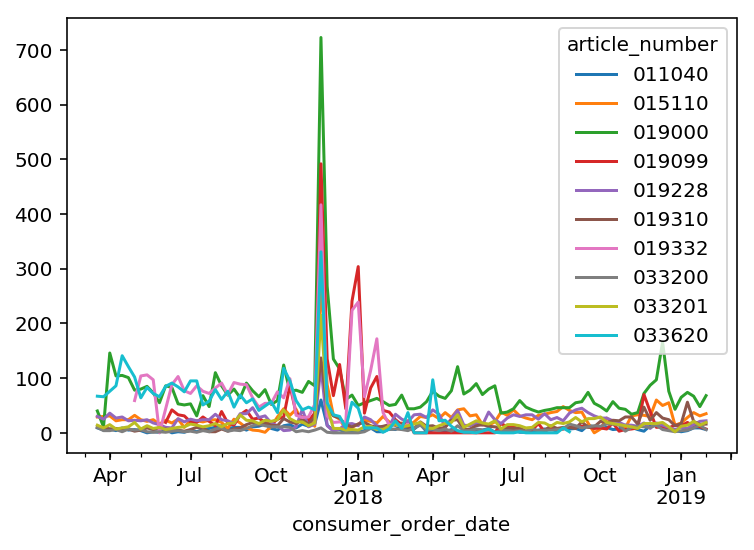

In [78]:
dat_g[1:100][['011040', '015110', '019000', '019099', '019228', '019310', '019332',
       '033200', '033201', '033620']].plot()